## Introduction

This notebook will guide you through the basic steps to get started with Active Vision.

By the end of this notebook, you will be able to:

- Understand the basic workflow of active learning
- Understand the basic components of Active Vision
- Understand how to use Active Vision to train a model
- Understand how to use Active Vision to iteratively improve your dataset

Before we start, we need to prepare 3 sets of data:

- Initial samples: A dataset of labeled images to train an initial model. If you don't have any labeled data, you can label some images yourself.
- Unlabeled samples: A dataset of unlabeled images. We will continuously sample from this set using active learning strategies.
- Evaluation samples: A dataset of labeled images. We will use this set to evaluate the performance of the model. This is the test set, DO NOT use it for active learning. Split this out in the beginning.

We will use the Imagenette dataset as a working example in this notebook.


## Load the dataset

`active-vision` currently supports datasets in a pandas dataframe format. The dataframe should have at least 2 columns: `filepath` and `label`.

In [1]:
import pandas as pd

initial_samples = pd.read_parquet("imagenette/initial_samples.parquet")
initial_samples.head()

,filepath,label
0,data/imagenette/2/00710.jpg,cassette player
1,data/imagenette/2/00063.jpg,cassette player
2,data/imagenette/2/00506.jpg,cassette player
3,data/imagenette/2/00575.jpg,cassette player
4,data/imagenette/2/00136.jpg,cassette player


Let's check the distribution of the labels.

In [2]:
initial_samples["label"].value_counts()


label
cassette player     10
tench               10
chain saw           10
church              10
parachute           10
gas pump            10
English springer    10
golf ball           10
garbage truck       10
French horn         10
Name: count, dtype: int64

## Create an ActiveLearner

Now that we have an initial dataset, we can load it into an `ActiveLearner` object with a model.

Any fastai and timm models are supported. For simplicity, we will use a `resnet18` model.

In [3]:
from active_vision import ActiveLearner
from fastai.vision.models.all import resnet18

al = ActiveLearner(resnet18)

2025-01-25 00:01:47.070 | INFO     | active_vision.core:load_model:41 - Loading fastai model resnet18


We can load the initial samples into the `ActiveLearner` object.

In [4]:
al.load_dataset(initial_samples, 
                filepath_col="filepath", 
                label_col="label", 
                batch_size=8)

2025-01-25 00:01:47.075 | INFO     | active_vision.core:load_dataset:59 - Loading dataset from filepath and label
2025-01-25 00:01:47.075 | INFO     | active_vision.core:load_dataset:61 - Creating dataloaders
2025-01-25 00:01:47.321 | INFO     | active_vision.core:load_dataset:83 - Creating learner
2025-01-25 00:01:47.473 | INFO     | active_vision.core:load_dataset:92 - Done. Ready to train.


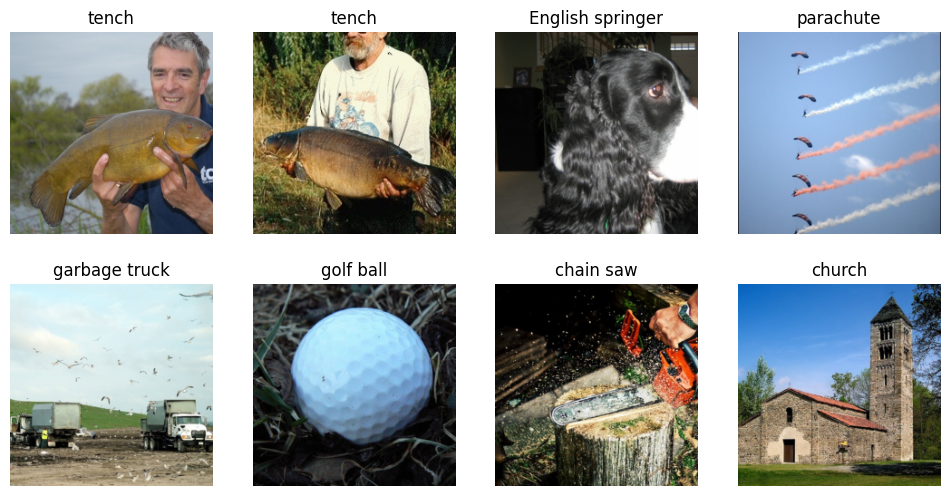

In [5]:
al.show_batch()

You can inspect the train and validation sets too.

In [6]:
al.train_set.head()

,filepath,label
51,data/imagenette/7/05378.jpg,gas pump
83,data/imagenette/6/07797.jpg,garbage truck
97,data/imagenette/5/08999.jpg,French horn
75,data/imagenette/8/06618.jpg,golf ball
9,data/imagenette/2/00420.jpg,cassette player


In [7]:
al.valid_set.head()

,filepath,label
4,data/imagenette/2/00136.jpg,cassette player
64,data/imagenette/1/06574.jpg,English springer
40,data/imagenette/9/04652.jpg,parachute
54,data/imagenette/7/05488.jpg,gas pump
20,data/imagenette/3/02629.jpg,chain saw


## Train 

Now that we have the initial dataset, we can train the model.

But first, let's check the optimal learning rate for the model.

2025-01-25 00:01:48.042 | INFO     | active_vision.core:lr_find:115 - Finding optimal learning rate


2025-01-25 00:01:54.456 | INFO     | active_vision.core:lr_find:117 - Optimal learning rate: 0.00363078061491251


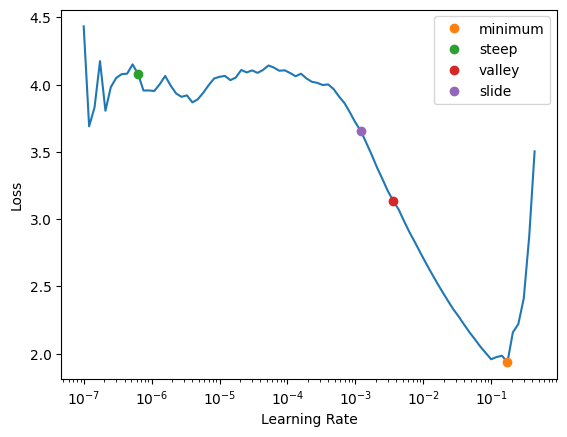

In [8]:
al.lr_find()

Not let's use the optimal learning rate to train the model end-to-end for 3 epochs and 1 epoch of head tuning.

2025-01-25 00:01:54.717 | INFO     | active_vision.core:train:128 - Training head for 1 epochs
2025-01-25 00:01:54.718 | INFO     | active_vision.core:train:129 - Training model end-to-end for 3 epochs
2025-01-25 00:01:54.718 | INFO     | active_vision.core:train:130 - Learning rate: 0.005 with one-cycle learning rate scheduler


epoch,train_loss,valid_loss,accuracy,time
0,2.871501,0.771290,0.750000,00:01


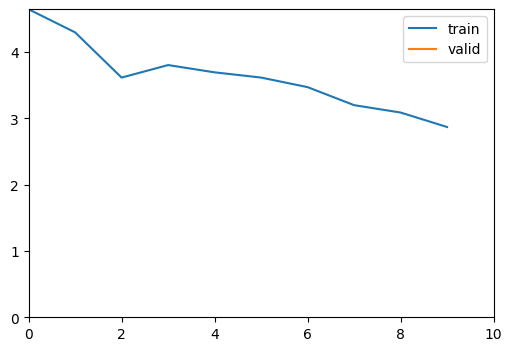

epoch,train_loss,valid_loss,accuracy,time
0,0.460057,0.409270,0.850000,00:01
1,0.370149,0.635701,0.800000,00:01
2,0.286742,0.720829,0.800000,00:01


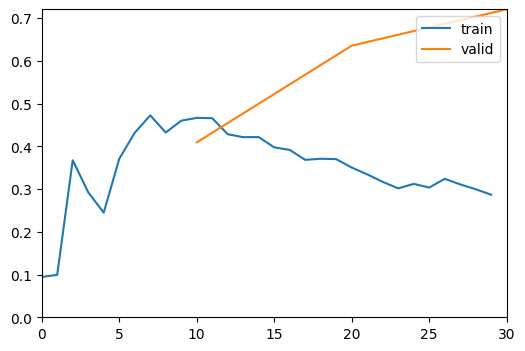

In [9]:
al.train(epochs=3, lr=5e-3, head_tuning_epochs=1)

## Evaluate

Now that we have a trained model, we can evaluate it on the evaluation set.

In [10]:
evaluation_df = pd.read_parquet("imagenette/evaluation_samples.parquet")
evaluation_df.head()

,filepath,label
0,data/imagenette/2/00000.jpg,cassette player
1,data/imagenette/2/00001.jpg,cassette player
2,data/imagenette/2/00002.jpg,cassette player
3,data/imagenette/2/00003.jpg,cassette player
4,data/imagenette/2/00004.jpg,cassette player


In [11]:
al.evaluate(evaluation_df, filepath_col="filepath", label_col="label")

2025-01-25 00:02:04.166 | INFO     | active_vision.core:evaluate:183 - Accuracy: 89.22%


0.8922292993630573